# DPSOM MNIST Visualization

This notebook loads a PyTorch/Lightning checkpoint for a DPSOM model, computes cluster assignments on MNIST test data, and visualizes:
- Heatmap of majority labels per SOM cell
- Reconstructed SOM centroids

In [1]:
import importlib
import numpy as np
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns


ex_name = "hyperopt_100_8-8_2025-11-12_65976"
ckpt_path = f"../models/{ex_name}/{ex_name}.ckpt"

Data: MNIST test set, per-image max normalization

In [2]:
mnist_test = datasets.MNIST(root="../data", train=False, download=True)
data_test = mnist_test.data.numpy().astype(np.float32)  # [N, 28, 28]
labels_val = mnist_test.targets.numpy()  # [N]

flat = data_test.reshape(len(data_test), -1)
maxx = np.max(flat, axis=1, keepdims=True)
maxx[maxx == 0.0] = 1.0
data_val = (flat / maxx).reshape(-1, 28, 28, 1).astype(np.float32)

Load model and weights from .ckpt

In [3]:
device = torch.device("cpu")

dm = importlib.import_module("dpsom_model")

# Allowlist optional config class for safe weights-only loading
import torch.serialization as ts
if not hasattr(dm, "DPSOMConfig"):
    class DPSOMConfig:
        def __init__(self, **kwargs):
            for k, v in kwargs.items():
                setattr(self, k, v)
    dm.DPSOMConfig = DPSOMConfig
try:
    ts.add_safe_globals([dm.DPSOMConfig])
except Exception:
    pass

try:
    obj = torch.load(ckpt_path, map_location=device, weights_only=True)
except Exception:
    obj = torch.load(ckpt_path, map_location=device, weights_only=False)

state = obj
if isinstance(state, dict):
    for k in ["state_dict", "model", "net", "weights", "params"]:
        if k in state and isinstance(state[k], dict):
            state = state[k]
            break

def _strip_prefix(sd, prefix):
    if any(k.startswith(prefix) for k in sd.keys()):
        return {k[len(prefix):]: v for k, v in sd.items()}
    return sd

state = _strip_prefix(state, "module.")
state = _strip_prefix(state, "model.")

embed_key = None
for k, v in state.items():
    if isinstance(v, torch.Tensor) and v.ndim == 3:
        embed_key = k
        break
if embed_key is None:
    raise KeyError("Could not find a 3D embeddings tensor in checkpoint (expected [H, W, D]).")

H, W, D = state[embed_key].shape
som_dim = [int(H), int(W)]
latent_dim = int(D)

is_conv = any(k.startswith("enc_conv") or ".enc_conv" in k for k in state.keys())

from dpsom_model import DPSOM
model = DPSOM(latent_dim=latent_dim, som_dim=som_dim, convolution=is_conv).to(device)
missing, unexpected = model.load_state_dict(state, strict=True)
model.eval()

DPSOM(
  (enc_fc1): Linear(in_features=784, out_features=500, bias=True)
  (enc_drop1): Dropout(p=0.5, inplace=False)
  (enc_bn1): BatchNorm1d(500, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (enc_fc2): Linear(in_features=500, out_features=500, bias=True)
  (enc_drop2): Dropout(p=0.5, inplace=False)
  (enc_bn2): BatchNorm1d(500, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (enc_fc3): Linear(in_features=500, out_features=2000, bias=True)
  (enc_drop3): Dropout(p=0.5, inplace=False)
  (enc_bn3): BatchNorm1d(2000, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (enc_mu): Linear(in_features=2000, out_features=100, bias=True)
  (enc_logvar): Linear(in_features=2000, out_features=100, bias=True)
  (dec_fc4): Linear(in_features=100, out_features=2000, bias=True)
  (dec_bn4): BatchNorm1d(2000, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (dec_fc3): Linear(in_features=2000, out_features=500, bias=True)
  (dec_

Deterministic cluster assignments (use encoder mean µ)

In [4]:
x_t = torch.from_numpy(data_val).permute(0, 3, 1, 2).contiguous().float().to(device)
with torch.no_grad():
    mu, _ = model._encode(x_t)  # [N, D]
    E = model.embeddings.to(mu.device)  # [H, W, D]
    diff = mu[:, None, None, :] - E[None, :, :, :]  # [N, H, W, D]
    dist = (diff * diff).sum(dim=-1)  # [N, H, W]
    k_all = dist.view(dist.shape[0], -1).argmin(dim=-1).cpu().numpy()  # [N]

Reconstruct SOM centroids by decoding each embedding

In [5]:
with torch.no_grad():
    E_flat = E.view(-1, latent_dim)  # [H*W, D]
    logits = model._decode_logits(E_flat)  # [H*W, 784]
    x_hat_all = torch.sigmoid(logits).view(H, W, 28, 28).cpu().numpy()  # [H, W, 28, 28]

Compute cluster label matrix (mean/majority label per SOM cell)

In [6]:
labels = labels_val  # [N], digits 0..9
H, W = som_dim
K = H * W
num_classes = 10

k_flat = np.reshape(k_all, (-1))
counts = np.zeros((K, num_classes), dtype=np.int64)
np.add.at(counts, (k_flat, labels.astype(np.int64)), 1)

totals = counts.sum(axis=1)
majority = np.full(K, np.nan, dtype=np.float32)
nonempty = totals > 0
majority[nonempty] = counts[nonempty].argmax(axis=1).astype(np.float32)

clust_matr1 = majority.reshape(H, W)

# Visualizations


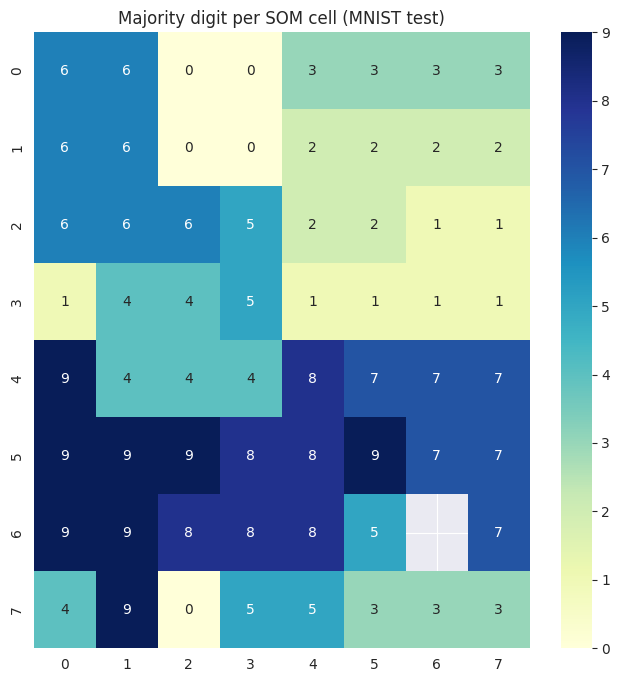

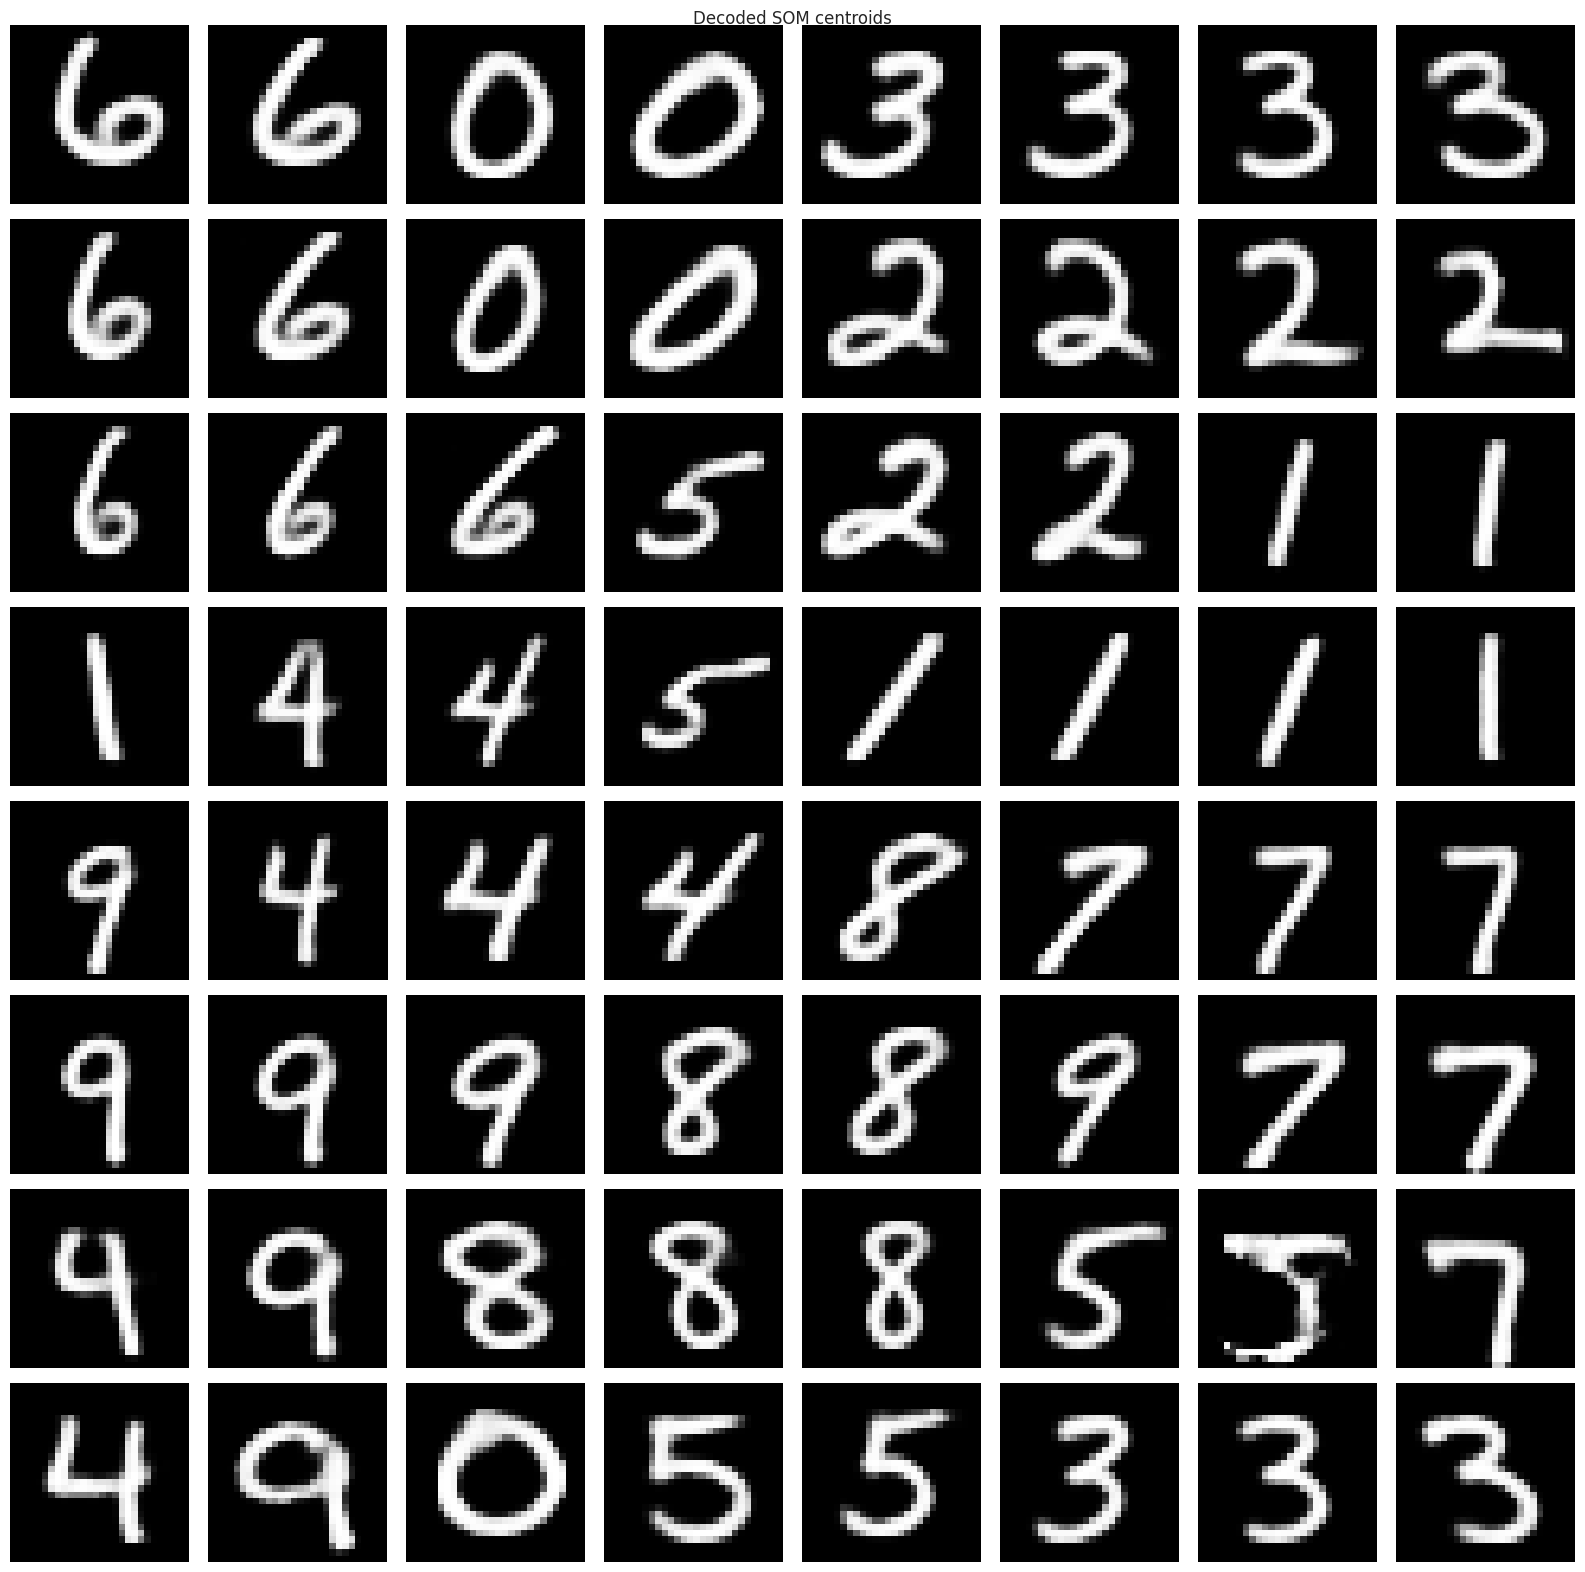

In [7]:
plt.figure(figsize=(max(6, W), max(4, H)))
ax = sns.heatmap(clust_matr1, cmap="YlGnBu", vmin=0, vmax=9, annot=True, fmt=".0f")
ax.set_title("Majority digit per SOM cell (MNIST test)")
plt.show()

fig, axes = plt.subplots(H, W, figsize=(min(20, 2*W), min(20, 2*H)))
for i in range(H):
    for j in range(W):
        axes[i, j].imshow(x_hat_all[i, j], cmap='gray')
        axes[i, j].axis('off')
plt.suptitle("Decoded SOM centroids")
plt.tight_layout()
plt.show()